In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import SFNO
from models.pfno import PNO_Wrapper, PFNO, PSFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import SSWEDataset
from evaluate import generate_samples
from utils.train_utils import autoregressive_step
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
import cmcrameri.cm as cmc
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

In [2]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 1


data_dir = "../../data/SSWE/processed/"

checkpoint_path = "/home/groups/ai/scholl/pfno/weights/sswe/fno/"

# 1 step ahead
sr_dropout_path = checkpoint_path + "20241002_140510_sswe_sfno_sr_dropout_1/Datetime_20241002_140512_Loss_SSWE_SFNO_scoring-rule-dropout_dropout_0.01.pt"
laplace_path = checkpoint_path + "20241001_113502_sswe_sfno_laplace_1/Datetime_20241001_113503_Loss_SSWE_SFNO_laplace_dropout_0.001.pt"
dropout_path = checkpoint_path + "20240925_134205_sswe_sfno_dropout_1/Datetime_20240925_134206_Loss_SSWE_SFNO_dropout_dropout_0.01.pt"
sr_reparam_path = checkpoint_path + "20241004_100858_sswe_sfno_reparam_1/Datetime_20241004_100900_Loss_SSWE_SFNO_scoring-rule-reparam_dropout_0.005.pt"

# 2 steps ahead
sr_dropout_path = checkpoint_path + "20241004_102958_sswe_sfno_sr_dropout_2/Datetime_20241004_102958_Loss_SSWE_SFNO_scoring-rule-dropout_dropout_0.01.pt"
laplace_path = checkpoint_path + "20241002_140510_sswe_sfno_laplace_2/Datetime_20241002_140512_Loss_SSWE_SFNO_laplace_dropout_0.001.pt"
dropout_path = checkpoint_path + "20241001_113458_sswe_sfno_dropout_2/Datetime_20241001_113459_Loss_SSWE_SFNO_dropout_dropout_0.01.pt"
sr_reparam_path = checkpoint_path + "20241008_125613_sswe_sfno_reparam_2/Datetime_20241008_125614_Loss_SSWE_SFNO_scoring-rule-reparam_dropout_0.005.pt"

In [3]:
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = False)
x,y,t = test_data.get_coordinates()
Lons, Lats = np.meshgrid(y,x)
L = test_data.get_domain_range()
weights = test_data.eval_weights
nlon = test_data.nlon

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
n_test = len(test_loader)

In [4]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.001).to(device)
la_model = LA_Wrapper(laplace_model)
la_model.load_state_dict(laplace_path)

pfno_reparam = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.005, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

# Predictions

In [5]:
# Generate random samples for plotting
np.random.seed(0)
torch.manual_seed(42)
samples = np.random.randint(0,n_test,1)

In [6]:
pfno_dropout.train()
dropout_model.train()
pfno_reparam.eval()
""" Prediction """
pred_pfno_dropout = []
pred_pfno_reparam = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        # Dropout
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("dropout", dropout_model, a)
        dropout_pred = generate_samples("dropout",dropout_model,a,u,n_samples)

        # LA
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("laplace", la_model, a)
        la_pred = generate_samples("laplace",la_model,a,u,n_samples)

        # PFNO Reparam
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("scoring-rule-reparam", pfno_reparam, a)
        pfno_reparam_pred = generate_samples("scoring-rule-reparam",pfno_reparam,a,u,n_samples)

        # PFNO Dropout
        for _ in range(eval_horizon - 1):
            a = autoregressive_step("scoring-rule-dropout", pfno_dropout, a)
        pfno_dropout_pred = generate_samples("scoring-rule-dropout",pfno_dropout,a,u,n_samples)

        pred_dropout.append( dropout_pred )
        pred_pfno_dropout.append( pfno_dropout_pred )
        pred_pfno_reparam.append( pfno_reparam_pred )
        pred_la.append( la_pred )


pred_pfno_dropout = torch.cat(pred_pfno_dropout, dim = 0).cpu().numpy()
pred_pfno_reparam = torch.cat(pred_pfno_reparam, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [13]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = np.power((truth - pred_array.mean(axis = -1)),2).min(), vmax = np.quantile(np.power((truth - pred_array.mean(axis = -1)),2), 0.99))
    std_norm = Normalize(vmin = 0, vmax = np.quantile(pred_array.std(axis = -1),0.995))
    

    fig, axs = plt.subplots(3,n_models, figsize = (18,12), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for m, pred in enumerate(preds):        
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,np.power((truth - pred.mean(axis = -1)),2), cmap = "cmc.vik", norm = mse_norm, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False,)
        im2 = axs[1,m].pcolormesh(lon, lat,pred.std(axis = -1), cmap = "cmc.lipari", norm = std_norm, rasterized = True, transform=ccrs.PlateCarree(), antialiased = False)
        im3 = axs[2,m].pcolormesh(lon, lat,coverage, cmap = cmap_coverage, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m], extend = "max")
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation", extend = "max")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(3):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [14]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Discrete colorbar
    viridis = cmp.get_cmap('viridis')    
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    pred_norm = Normalize(vmin = pred_array.mean(axis = -1).min(), vmax = pred_array.mean(axis = -1).max())
    std_norm = Normalize(vmin = 0, vmax = np.quantile(pred_array.std(axis = -1),0.995))
    

    fig, axs = plt.subplots(4,n_models, figsize = (18,15), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for m, pred in enumerate(preds):        
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(lon, lat ,truth , cmap = "cmc.vik", rasterized = True,transform=ccrs.PlateCarree(), antialiased = False, norm = pred_norm)
        im1 = axs[1,m].pcolormesh(lon, lat ,pred.mean(axis = -1), cmap = "cmc.vik", norm = pred_norm, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False)
        im2 = axs[2,m].pcolormesh(lon, lat,pred.std(axis = -1), cmap = "cmc.lipari", norm = std_norm, rasterized = True, transform=ccrs.PlateCarree(), antialiased = False)
        im3 = axs[3,m].pcolormesh(lon, lat,coverage, cmap = cmap_coverage, rasterized = True,transform=ccrs.PlateCarree(), antialiased = False)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth',size=title_size)
    cb2 = fig.colorbar(im1, ax = axs[1,m])
    cb2.ax.tick_params(labelsize=tick_size) 
    cb2.set_label('Mean prediction',size=title_size)
    cb3 = fig.colorbar(im2, ax = axs[2,m], label = "Standard deviation", extend = "max")
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label('Standard deviation',size=title_size)
    cb4 = fig.colorbar(im3, ax = axs[3,m], label = "", ticks = np.array([0,1]))
    cb4.ax.tick_params(labelsize=tick_size)
    cb4.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    for i in range(4):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plots

In [15]:
idx = 0
channel = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()[:,channel]

preds = [pred_dropout[idx, channel], pred_la[idx,channel], pred_pfno_dropout[idx, channel], pred_pfno_reparam[idx, channel]]
names = ['MCD', 'LA', r'$\mathrm{PNO_{D}}$', r'$\mathrm{PNO_{R}}$']

MCD- Coverage: 0.62158203125
LA- Coverage: 0.98699951171875
$\mathrm{PNO_{D}}$- Coverage: 0.96734619140625
$\mathrm{PNO_{R}}$- Coverage: 0.0335693359375


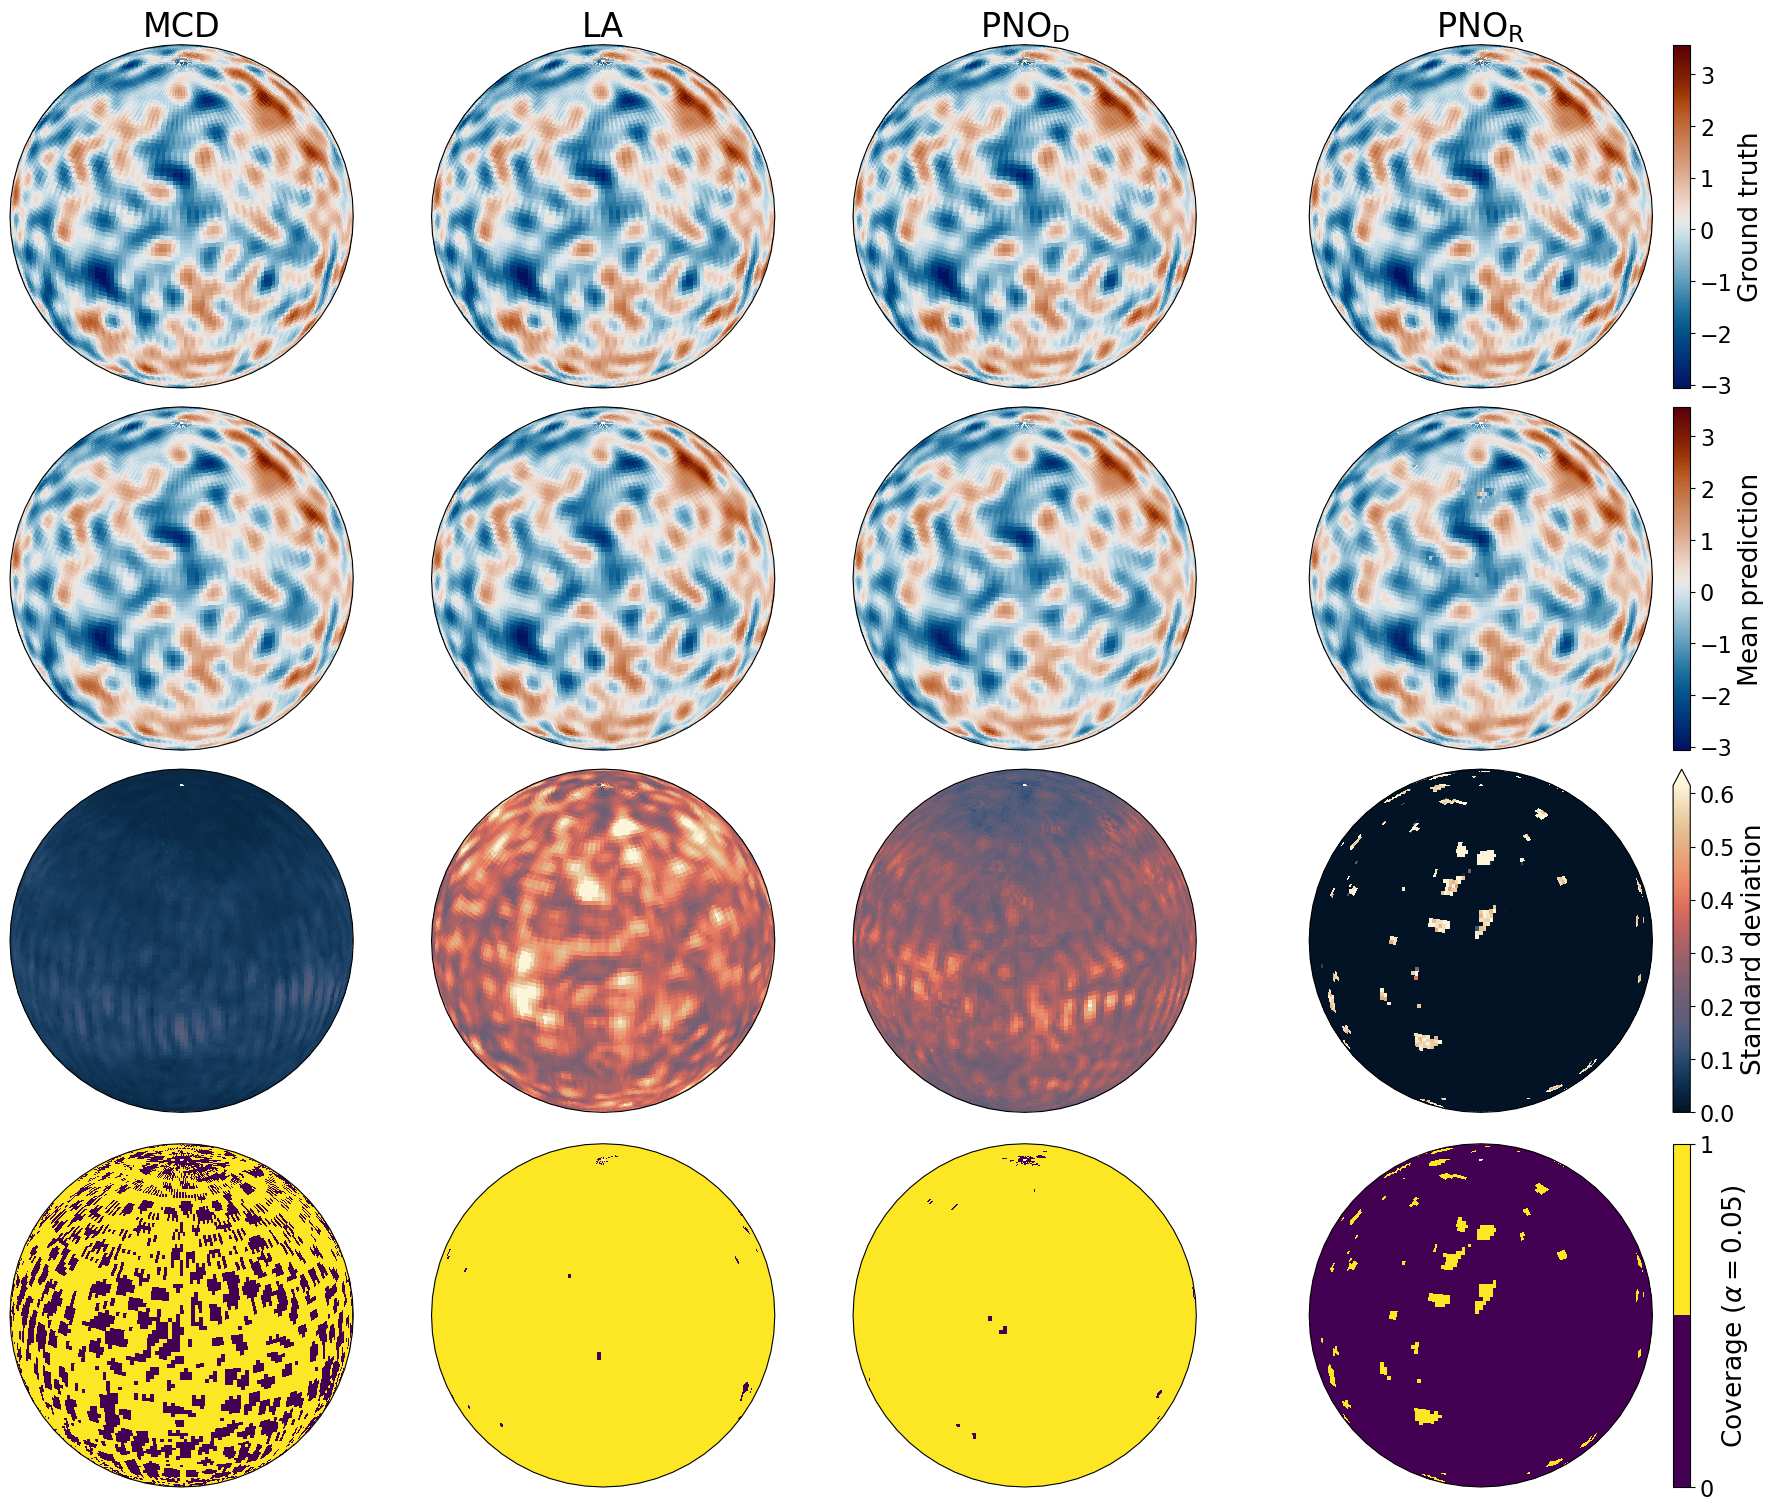

In [16]:
plot_predictions(u, preds, names, (Lats,Lons), save_path = f"plots/sswe_predictions_{eval_horizon}h.pdf", alpha = 0.05)

MCD- Coverage: 0.62158203125
LA- Coverage: 0.98699951171875
$\mathrm{PNO_{D}}$- Coverage: 0.96734619140625
$\mathrm{PNO_{R}}$- Coverage: 0.0335693359375


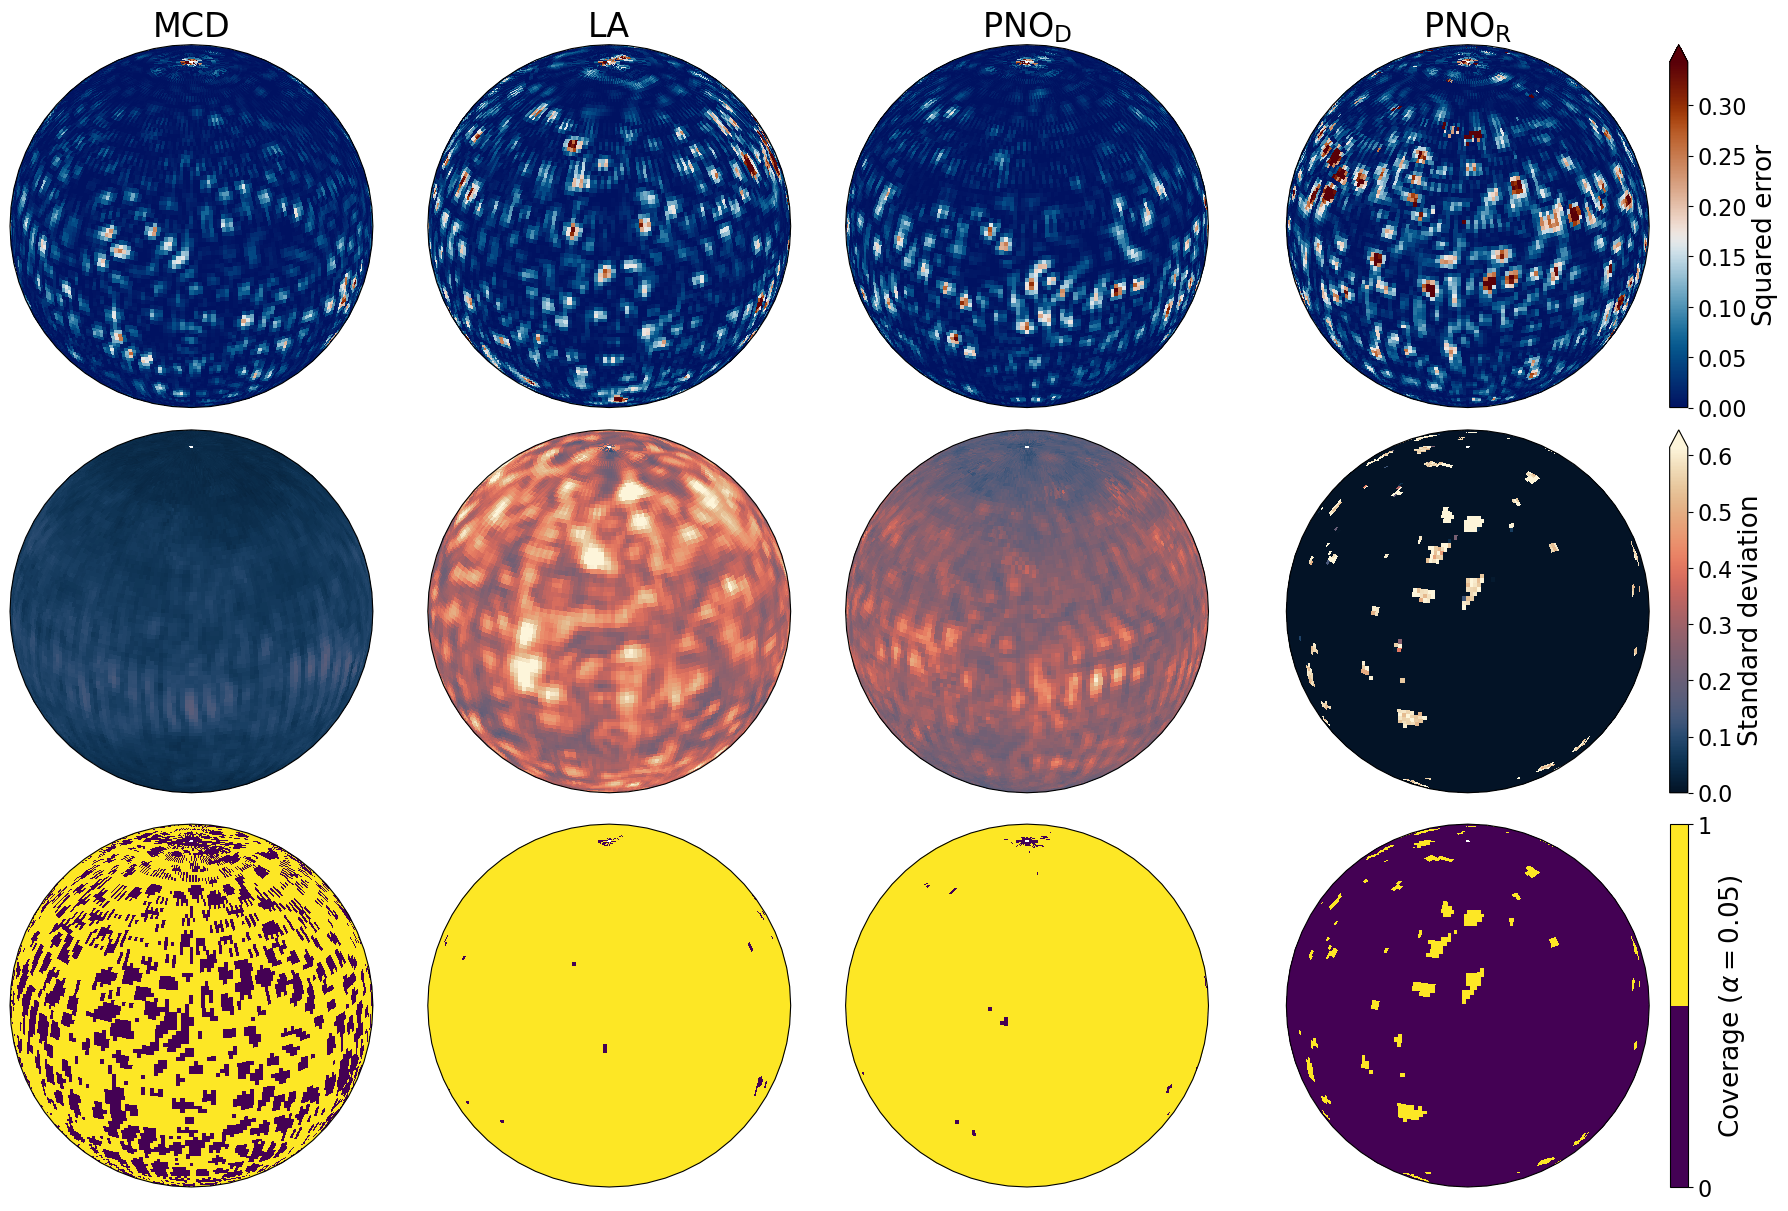

In [17]:
plot_statistics(u, preds, names, (Lats,Lons), save_path = f"plots/sswe_statistics_{eval_horizon}h.pdf", alpha = 0.05)

# Plot time dynamics of PFNO

In [12]:
batch_size = 16
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_steps = 5
eval_horizon = 25


# Hres
data_dir = "../../data/SSWE/processed/"

checkpoint_path = "/home/groups/ai/scholl/pfno/weights/sswe/fno/"

# 2 steps ahead
sr_dropout_path = checkpoint_path + "20241004_102958_sswe_sfno_sr_dropout_2/Datetime_20241004_102958_Loss_SSWE_SFNO_scoring-rule-dropout_dropout_0.01.pt"
laplace_path = checkpoint_path + "20241002_140510_sswe_sfno_laplace_2/Datetime_20241002_140512_Loss_SSWE_SFNO_laplace_dropout_0.001.pt"
dropout_path = checkpoint_path + "20241001_113458_sswe_sfno_dropout_2/Datetime_20241001_113459_Loss_SSWE_SFNO_dropout_dropout_0.01.pt"
sr_reparam_path = checkpoint_path + "20241008_125613_sswe_sfno_reparam_2/Datetime_20241008_125614_Loss_SSWE_SFNO_scoring-rule-reparam_dropout_0.005.pt"

In [13]:
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_steps, return_all = True)
x,y,t = test_data.get_coordinates()
Lons, Lats = np.meshgrid(y,x)
L = test_data.get_domain_range()
weights = test_data.eval_weights
nlon = test_data.nlon

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
n_test = len(test_loader)

In [14]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.001).to(device)
la_model = LA_Wrapper(laplace_model)
la_model.load_state_dict(laplace_path)

pfno_reparam = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.005, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, dropout = 0.01).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

In [15]:
def plot_error_dynamics(truth, pred, sd, name, steps, scaling, grid, save_path = None, alpha = 0.05):
    n_steps = len(steps)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Get scalings
   # pred_array = np.array(preds)
    mse_norm = Normalize(vmin = np.power((pred - truth),2).min(), vmax = np.power((pred-truth),2).max())
    sd_norm = Normalize(vmin = sd.min(), vmax = sd.max())
    

    fig, axs = plt.subplots(2,n_steps, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for t, step in enumerate(steps):        
        pred = pred.squeeze()
        # Calculate coverage
        im1 = axs[0,t].pcolormesh(lon, lat ,np.power((truth[step]-pred[step]),2), cmap = "cmc.vik", rasterized = True,transform=ccrs.PlateCarree(), antialiased = False, norm = mse_norm)
        im2 = axs[1,t].pcolormesh(lon, lat, sd[step], cmap = "cmc.lipari", rasterized = True, transform=ccrs.PlateCarree(), antialiased = False, norm = sd_norm)
        axs[0,t].set_title(f"+{step*scaling+1}h", fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,t])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,t])
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label("Standard deviation",size=title_size)

    for i in range(2):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [16]:
def plot_dynamics(truth, pred, sd, name, steps, scaling, grid, save_path = None, alpha = 0.05):
    n_steps = len(steps)
    lat, lon = grid
    truth = truth.squeeze()

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size


    # Define projection
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)

    # Get scalings
   # pred_array = np.array(preds)
    truth_norm = Normalize(vmin = truth.min(), vmax = truth.max())
    pred_norm = Normalize(vmin = pred.min(), vmax = pred.max())
    sd_norm = Normalize(vmin = sd.min(), vmax = sd.max())
    

    fig, axs = plt.subplots(3,n_steps, figsize = (20,10), sharex=True, sharey=True, subplot_kw={'projection': proj},
                            layout = "constrained")

        
    for t, step in enumerate(steps):        
        pred = pred.squeeze()
        # Calculate coverage
        im1 = axs[0,t].pcolormesh(lon, lat ,truth[step], cmap = "cmc.vik", rasterized = True,transform=ccrs.PlateCarree(), antialiased = False, norm = truth_norm)
        im2 = axs[1,t].pcolormesh(lon, lat, pred[step], cmap = "cmc.vik", rasterized = True, transform=ccrs.PlateCarree(), antialiased = False, norm = truth_norm)
        im3 = axs[2,t].pcolormesh(lon, lat, sd[step], cmap = "cmc.lipari", rasterized = True, transform=ccrs.PlateCarree(), antialiased = False, norm = sd_norm)
        axs[0,t].set_title(f"+{step*scaling+1}h", fontsize = 24)

    cb1 = fig.colorbar(im1, ax = axs[0,t])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,t])
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Mean prediction',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,t])
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label("Standard deviation",size=title_size)

    for i in range(3):
        axs[i,0].set_xticks([])
        axs[i,0].set_yticks([])
   # fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plot prediction history

In [17]:
# Generate random samples for plotting
np.random.seed(2)
samples = np.random.randint(0,n_test,1)

In [18]:
model = pfno_reparam
name = "scoring-rule-reparam"
""" Prediction """
pred_pfno = []
sd_pfno = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)

        # PFNO
        out = generate_samples(name,model,a,u[:,:,0],n_samples)#model(a, n_samples = n_samples)
        sd_pfno.append( out.std(axis = -1) )
        out = out.mean(axis = -1)
        pred_pfno.append( out )

        for _ in range(1,eval_horizon):        
            out = generate_samples(name,model,out,u[:,:,0],n_samples)#model(out, n_samples = n_samples)
            sd_pfno.append( out.std(axis = -1) )
            out = out.mean(axis = -1)
            pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
sd_pfno = torch.cat(sd_pfno, dim = 0).cpu().numpy()

In [19]:
channel = 0

pred = pred_pfno[::5, channel]
sd = sd_pfno[::5, channel]
truth = truth[channel,:]

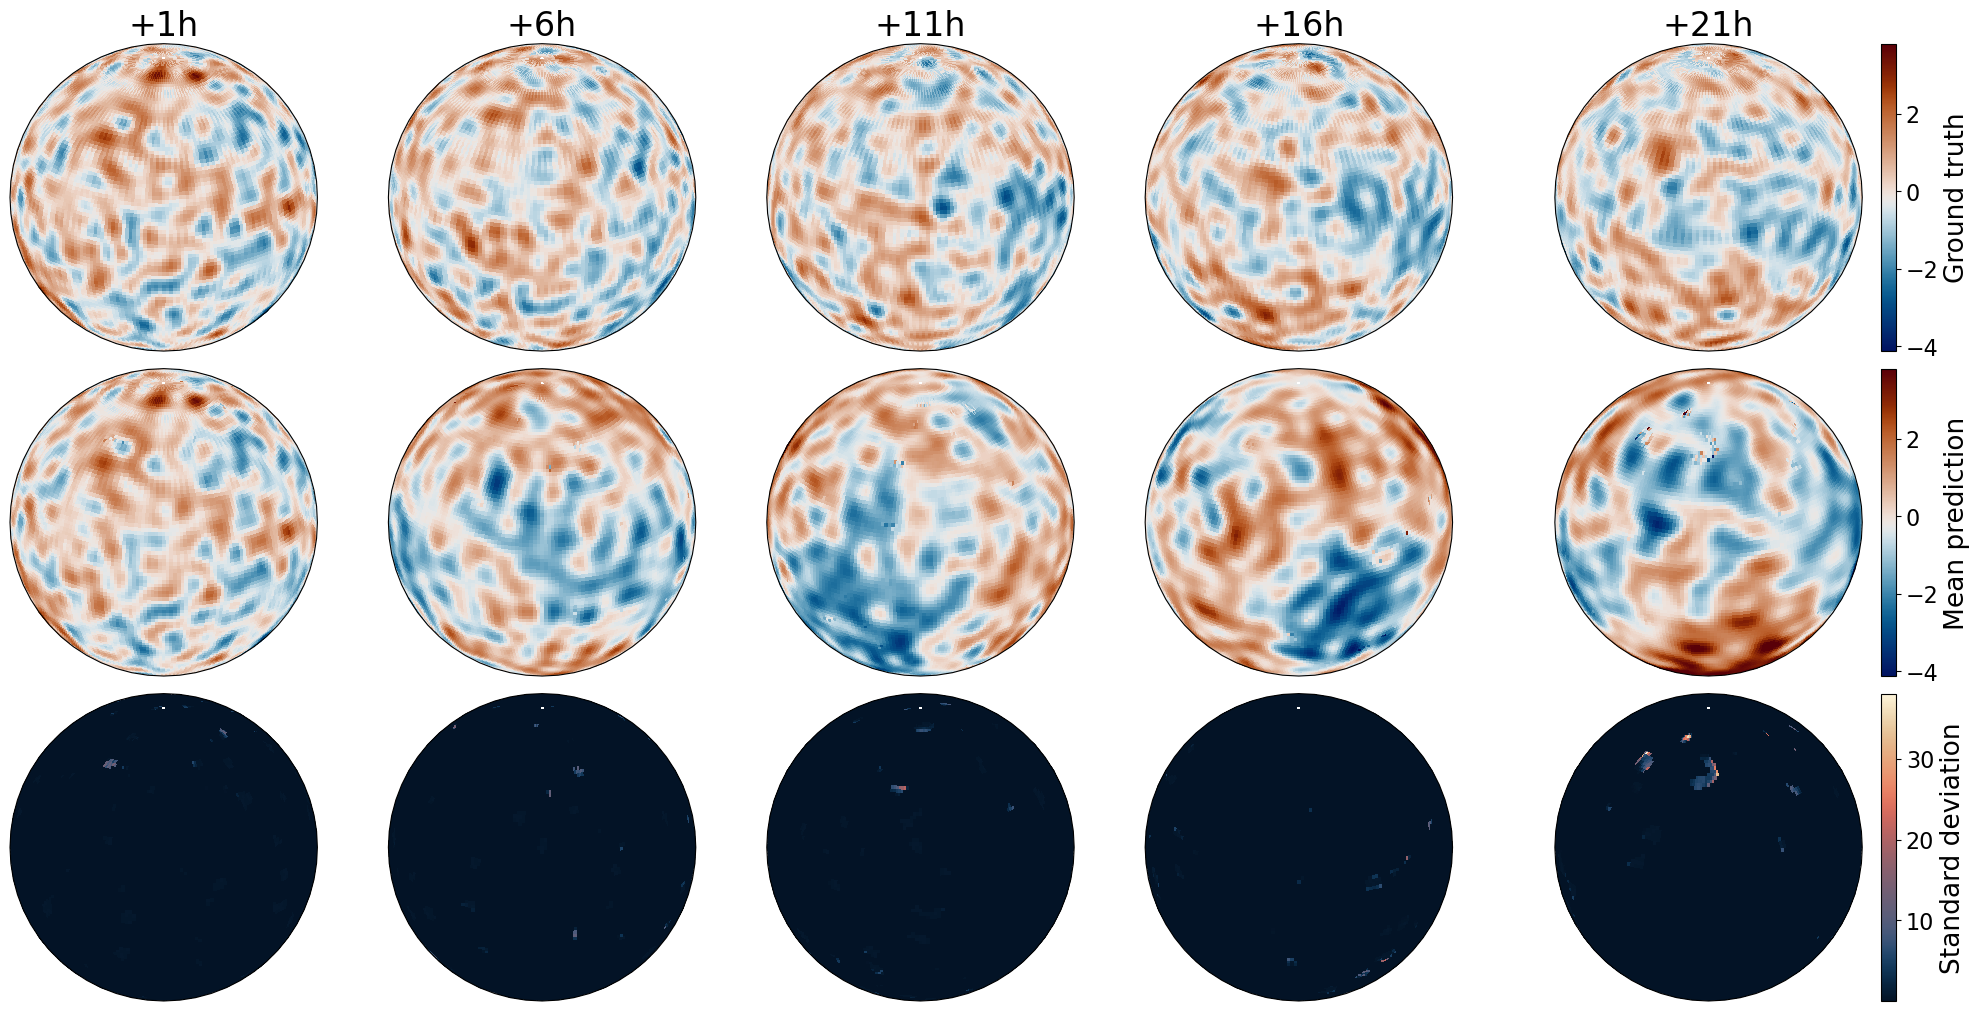

In [20]:
plot_dynamics(truth, pred, sd, name, steps = [0,1,2,3,4], scaling = 5, grid = (Lats, Lons), save_path= f"plots/sswe_prediction_dynamics_{name}.pdf")

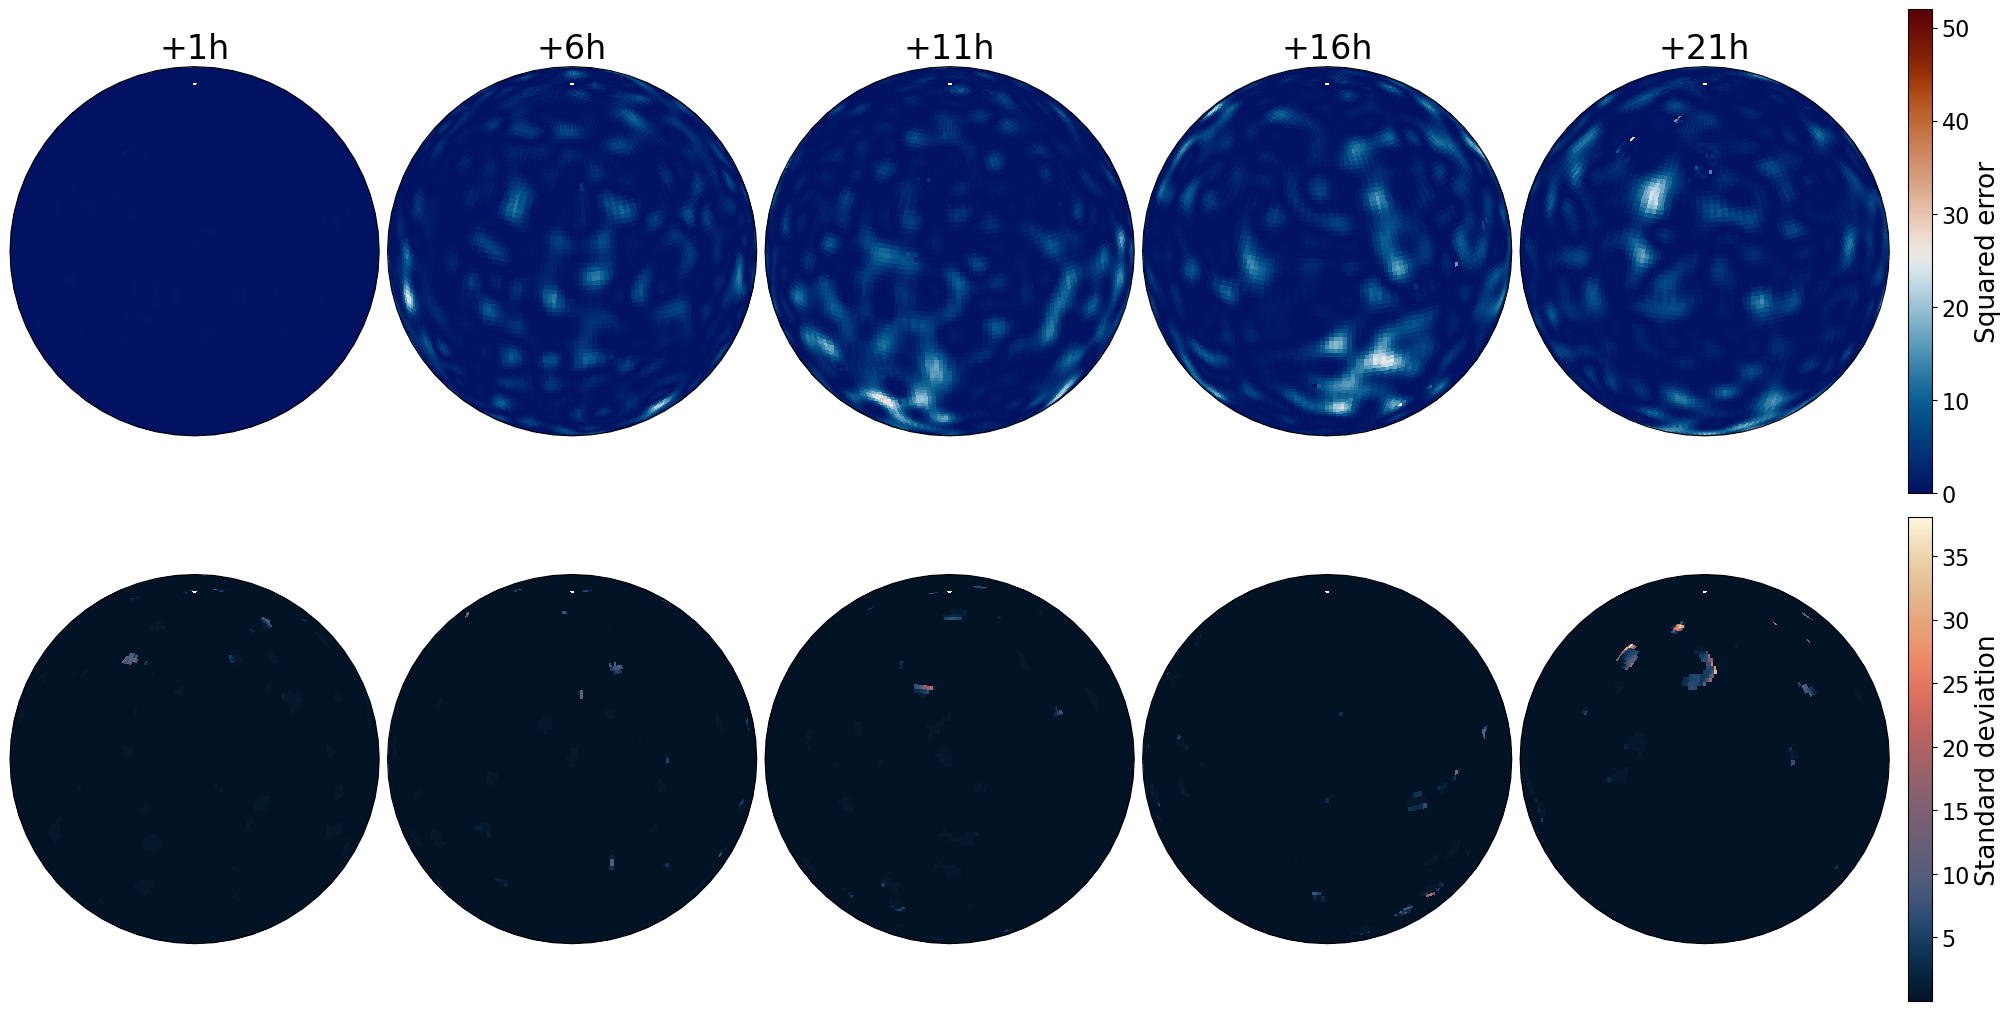

In [21]:
plot_error_dynamics(truth, pred, sd,name, steps = [0,1,2,3,4], scaling = 5, grid = (Lats, Lons), save_path= f"plots/sswe_error_dynamics_{name}.pdf")